# Practical 3: EnKF in L96

The objective of this practical is to perform DA experiments in the Lorenz-96 model with an ensemble Kalman
filter testing out the impact of the type of Kalman filter, inflation and localisation on the DA performance.

The differential equations of the Lorenz-96 model are given as
\begin{equation}
\frac{\partial x_{n}}{\partial t} = (x_{n+1}-x_{n-2})x_{n-1} - x_{i} + F
\end{equation}
with $0 \leq n < N_{x}$, and $x_{n}(t)$ assumed to be periodic, e.g. $x_{N_{x}}(t)=x_{0}(t)$. 

Let's start with importing all functions that will be used in this practical. 

In [1]:
import numpy as np
from tools.L96_model import lorenz96
from tools.plots import plotL96, plot_LocMatrix, plotL96obs
from tools.enkf_exp import Experiment

## Nature run

This section generates the nature run of the experiment, i.e. what we consider to be
the truth. You can change the initial condition `x0`, the final time `tmax` (consider that the model time
step is 0.025 time units), the number of variables `Nx` and the forcing `F` in the model. For the benefit of speed
and in order to display figures in an easier manner, we will use `Nx = 12`.

This model can be run from any given initial condition, but the default is to spin it up from a
perturbation around the unstable fixed point of the system $x_{n}(t)=F\,\forall n$. 
You will get a Hovmoller diagram (a contour plot showing the time evolution of the different variables 
in a circle of latitude), as well as a figure with $N_{x}$ panels. 

We also create a new initial condition that is different from the truth in `xguess`. 
In the end, we want data assimilation to bring the model run started off from this perturbed initial condition 
closer to the truth. 

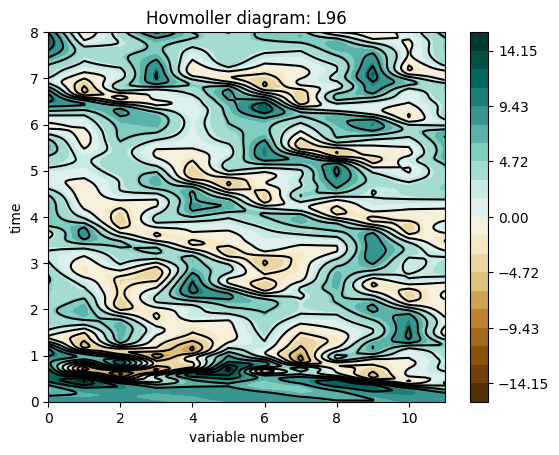

In [2]:
model = 'L96' #Model to be used. 
Nx = int(12) # number of state variables. Must be multiple of 4.
F = 8 #Forcing
x0 = np.array([0.,.05] + (Nx-2)*[0.]) + F # let it spin from rest (x_n(t=0) = F, forall n apart n=1)
tmax = 8 # The final time of the nature run simulation
discard = 20 #Spinup period to discard from output. 
dt = 0.025 #Time step integration scheme.

#Create truth.
t = np.arange(0, tmax+dt, dt)
xt = lorenz96(x0, tmax, dt, discard, F)

#Plot truth.
plotL96(t, np.array(xt), Nx, model)

#Initial conditions different from truth.
np.random.seed(100)
xguess = xt[:,0] + np.random.normal(size=np.shape(xt[:,0]))

## Data assimilation

Next, we will create an experiment object. This object holds the settings and results for our Lorenze-96 ensemble Kalman filter
experiments. An experiment using default settings can be created with `exp = Experiment(x0=x0, t=t, xt=xt)` where `x0` is the initial condition, `xt` is the truth model trajectory, `t` is the time coordinate. The forcing of the Lorenz-96 model can be modified by `exp = Experiment(x0=x0, t=t, xt=xt, F=forcing)`. After creation, 
the experiment can be run using `exp.run()` can be carried out.

The default setup of each experiment has 24 ensemble members using serial ensemble Kalman filter. The default
settings can be overwritten by passing them to the initialiser. E.g. `exp = Experiment(x0=x0, t=t, xt=xt, n_ens=12)` creates an
experiment that uses the default settings for all parameters except the ensemble size `n_ens`. This has been changed
from the default 24 members to 12 members.

In this experiment, we create "artificial" observations from the truth we just generated. This is done by applying the 
linear operator $\mathbf{H}$ to the state $x(t)$.
$\mathbf{H}$ can take on many shapes, e.g. $\mathbf{H}$ can observe all variables (`obs_grid='all'`),
every other variables (`obs_grid='1010'`), the first 6 variables/half of the domain (`obs_grid='landsea'`), or six observations of a footprint (`obs_grid='foot_6', footprint=3`) . The observation options can be given when the experiment is initialised by `Experiment(..., obs_grid='1010)`.

By default, the state is observed at every time step, but you can set the number of time steps between
observations with the input argument `period_obs`.
    
Finally, we add some white random noise to our samples of the nature run. This noise represents the 
observational errors from e.g. instrument errors. The observational error covariance matrix $\mathbf{R}$ is 
assumed to be diagonal (common assumption), but you can set the observational variance (i.e. the values on 
the diagonal of $\mathbf{R}$) with `var_obs`.  The default value for `var_obs` is 2.

In summary, the observations at time $t$, $y(t)$, are given as $y(t) = \mathbf{H}x(t) + \epsilon(t)$. Here
$\epsilon(t)$ is a random realisation from the normal distribution $\mathcal{N}(0,\mathbf{R})$. The settings
to generate observations together with a plot of them are created in the next cell. 

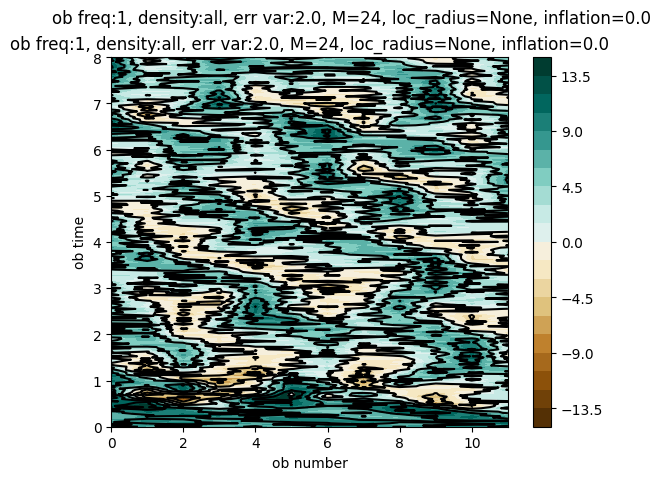

In [3]:
# for the sake of creating observations, the initial conditon has to be the same as the truth
exp = Experiment(x0=x0, t=t, xt=xt)
exp.create_observations()

#Plot the truth together with observations. 
plotL96obs(exp.tobs, exp.y, exp.n_obs, str(exp))

## State estimation

In this section we will set the observational standard deviation to
$\sigma_{obs}=\sqrt{2}$, and look at the effect of varying the following: the observational frequency `period_obs`, 
the observation density `obs_grid`, the ensemble size `n_ens`. 

### Stochastic ensemble Kalman filter
First, we will try to assimilate the observations using the default DA method, stochastic ensemble Kalman filter (`da_method='SEnKF'`). 
For reference, in the stochastic ensemble Kalman filter the analysis of the $n$th ensemble member, $x^{a,(n)}$, 
i.e. the ensemble member after the application of DA, is given by 

\begin{equation}
    x^{a,(n)} = x^{b,(n)} + \mathbf{K}(y - \mathbf{H}x^{b,(n)} + \mathbf{R}^{\frac{1}{2}}\epsilon^{(n)})
\end{equation}

Here $x^{b,(n)}$ is the model state in the $n$th ensemble member before DA at a time $t$, 
$\epsilon$ a realisation from the normal distribution $\mathcal{N}(0,\mathbf{R})$ and 

\begin{equation}
\mathbf{K} = \mathbf{P}^{f} \mathbf{H}^{\rm{T}} (\mathbf{H} \mathbf{P}^{f} \mathbf{H}^{\rm{T}} + \mathbf{R})^{-1}
\end{equation}

the Kalman gain matrix with background error covariance
\begin{equation}
\mathbf{P}^{f} = \frac{1}{N_{ens}-1} \sum_{n=1}^{N_{ens}} (x^{b,(n)}-\overline{x^{b}}) 
(x^{b,(n)}-\overline{x^{b}})^{\rm{T}}
\end{equation}

and $\overline{x^{b}} = \frac{1}{N_{ens}}\sum_{n=1}^{N_{ens}} x^{b,(n)}$ the forecast ensemble mean.

We rerun the model with the perturbed initial condition and assimilate all variables every 10 time steps. We plot the truth (black) together with the output just after the DA correction (purple). 
The 1st plot shows all ensemble members, the 2nd one only the ensemble mean. Finally, we also plot 
the spread (standard deviation) of the ensemble and the root-mean-squared error (RMSE). I.e. the
RMS between the ensemble mean of the background/analysis and the truth.

,rmse,spread
DA,,
background,0.330320,0.242508
analysis,0.304848,0.219727


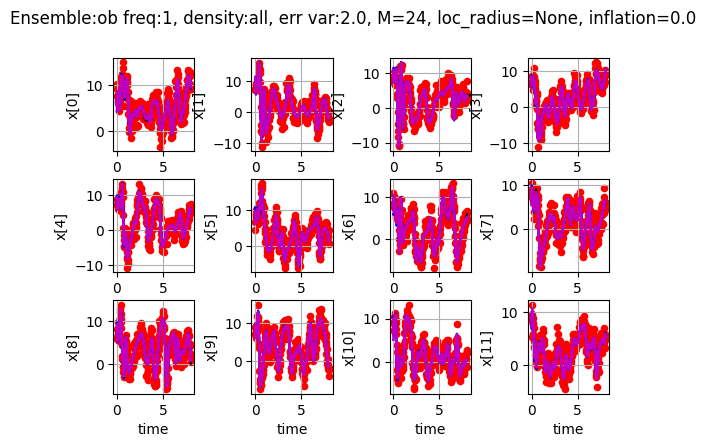

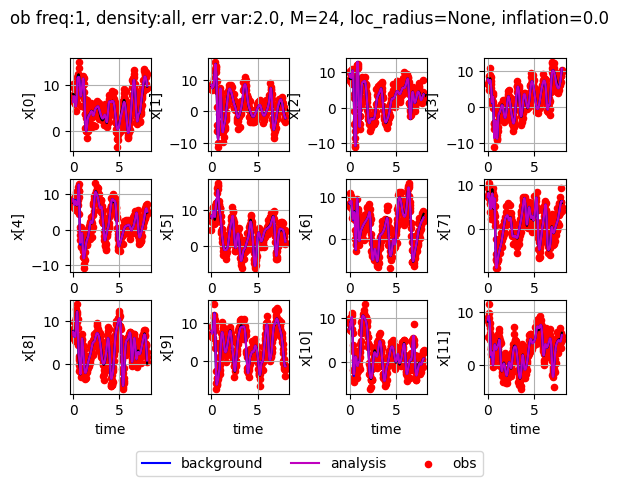

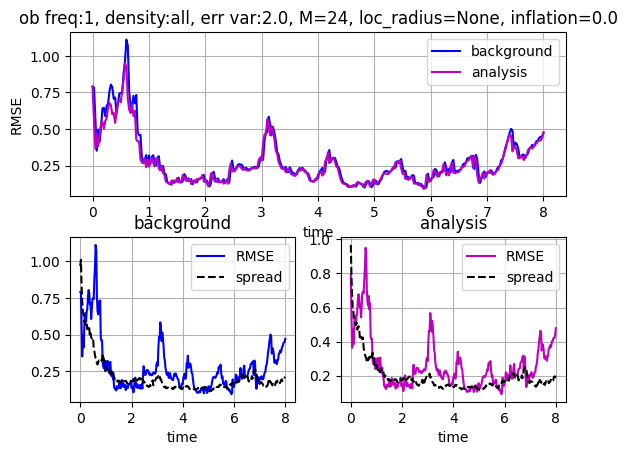

In [4]:
#Create experiment with a initial state that deviates from the truth. 
exp = Experiment(x0=xguess, t=t, xt=xt)

#Run the experiment
exp.run()

#Plot model output
exp.plot_state()

#Plot metrics as function of every nstep.
nstep = 1
exp.plot_metrics(nstep)

#Calculate and show as table the root-mean-square values over time. 
np.sqrt((exp.calculate_metrics(1)**2).mean(dim=['time'])).to_dataframe()

1. Rerun the aforementioned experiment but now add `period_obs=2` and plot the RMSE (hint: `exp = Experiment(x0=xguess, t=t, xt=xt, period_obs=2)`). 
Repeat with `period_obs=20`. How does observational frequency influence the output?

2. Try running the experiment with `x0=xguess, obs_grid='1010'` and `x0=xguess, obs_grid='landsea'`. 
How does the type of observations influence the output?

3. Try running with an 6-member ensemble (`x0=xguess, n_ens=6`) and a 12-member ensemble (`x0=xguess, n_ens=16`). 
How does the ensemble size influence the output?

## Inflation

Now let us try a more challenging setting by limiting our ensemble size from $N_{ens}=24$ to $N_{ens} = 12$.

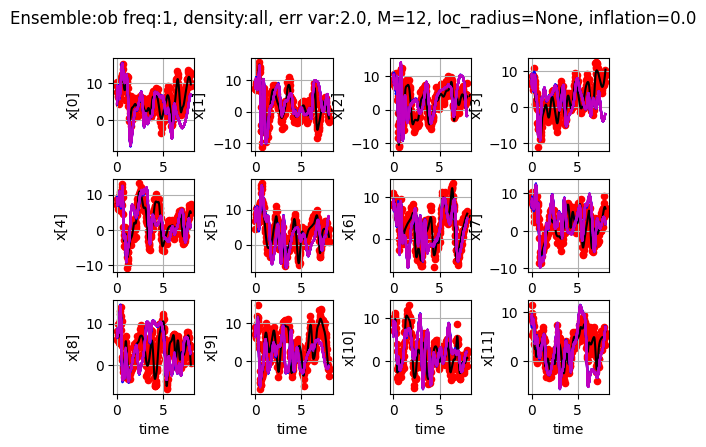

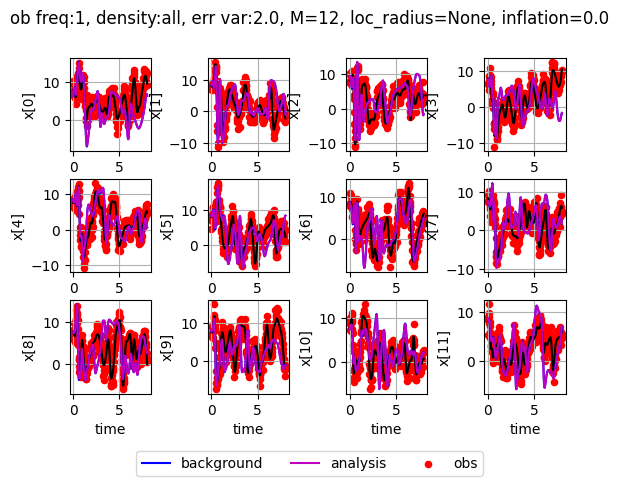

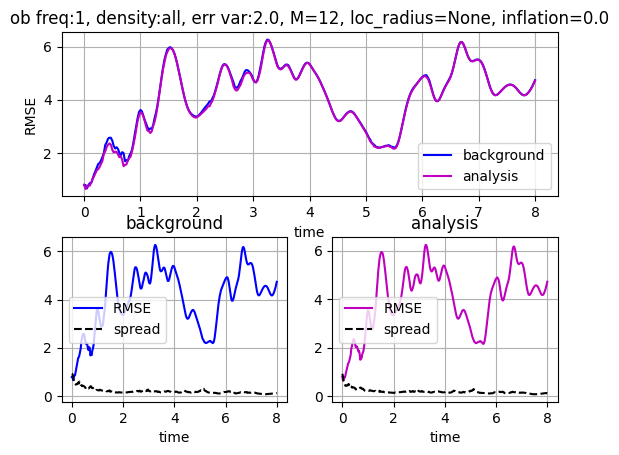

In [5]:
#Create experiment with a initial state that deviates from the truth and with 12 ensemble members.
exp = Experiment(x0=xguess, t=t, xt=xt, n_ens=12)

#Run the experiment
exp.run()

#Plot the experiment's output. 
exp.plot_state()

#Plot metrics
exp.plot_metrics(1)

The fundamental *ansatz* of ensemble Kalman
filters is that the truth and each ensemble member are realisation of the same probability distribution. I.e. the
truth can be viewed as another, but unknown, ensemble member. So, the standard deviation of the truth 
around the ensemble mean is equal to that of the ensemble members. The square-root of the former is 
the RMSE, that of the latter the ensemble spread. So, if the system is properly calibrated the expectation value
$E[\frac{{RMSE}^2}{\sigma_{ens}^2}]=1$. 

Clearly, this is not the case in this experiment: the spread severely 
underestimates the RMSE after $t=2$. One way to solve this is to use inflation. Inflation increases the spread 
by rescaling the ensemble. The most common approach is to multiply the perturbations from the ensemble mean
by a factor. In this practical, the an inflation factor of $\alpha$ means that the $n$th ensemble member after inflation is
given as $(1+\alpha)(\mathbf{x}^{b,(n)}-\overline{\mathbf{x}^{b}}) + \overline{\mathbf{x}^{b}}$ with $\overline{\mathbf{x}}$
the ensemble mean and $\mathbf{x}^{(n)}$ the $n$th ensemble member. 

4. Try different values for `inflation` always in combination with `x0=xguess, n_ens=12`. (hint: `exp = Experiment(x0=xguess, t=t, xt=xt, n_ens=12, inflation=0.0)`)
What is the smallest value for which spread and RMSE approximately match?

5. Repeat 4. but now using `obs_grid='1010'`. What is now the smallest inflation factor for which spread and 
RMSE match?

Theoretically the covariance after the DA step (i.e. analysis covariance) should be given as
\begin{equation}
    \mathbf{P}^{a} = \mathbf{P}^{f} - \mathbf{P}^{f}\mathbf{H}^{\rm{T}}(\mathbf{R}+\mathbf{H}\mathbf{P}^{f}\mathbf{H}^{\rm{T}})^{-1}\mathbf{H} \mathbf{P}^{f}
\end{equation}    

For SEnKF this equality only holds on average, i.e.
\begin{equation}
E[ \frac{1}{N_{ens}-1} \sum_{n=1}^{N_{ens}} (x^{a,(n)}-\overline{x^{a}}) 
(x^{a,(n)}-\overline{x^{a}})^{\rm{T}} ] = \mathbf{P}^{a}
\end{equation}
However, single instances of 
\begin{equation}
\frac{1}{N_{ens}-1} \sum_{n=1}^{N_{ens}} (x^{a,(n)}-\overline{x^{a}}) 
(x^{a,(n)}-\overline{x^{a}})^{\rm{T}}
\end{equation}
might differ from $\mathbf{A}$. 

The ensemble transform Kalman filter (ETKF) is an alternative to SEnKF in which no perturbations are added to the 
observations.
Instead a linear combination of background ensemble states is sought such that 
\begin{equation}
\mathbf{\tilde{X}}^{a} = \mathbf{\tilde{X}}^{b} \mathbf{T}
\end{equation}
and $\frac{1}{N_{ens}-1}\mathbf{\tilde{X}}^{a} \mathbf{\tilde{X}}^{a,\rm{T}} = \mathbf{P}^{a}$. 
Here the $n$th-column of $\tilde{\mathbf{X}}$ is $x^{(n)}-\overline{x}$ the perturbation 
of the $n$th-ensemble member from the ensemble mean. Rewriting $\mathbf{P}^{a}$ as 
\begin{equation}
\mathbf{P}^{a} \overset{def}{=} \mathbf{\tilde{X}}^{b} \mathbf{T} \mathbf{T}^{\rm{T}} \mathbf{\tilde{X}}^{b,\rm{T}}
\end{equation}
gives that the aforementioned equality can be achieved by setting 
\begin{equation}
\mathbf{T} = \mathbf{U} \mathbf{\Lambda}^{-1/2} \mathbf{U}^{\rm{T}}
\end{equation}
with $\mathbf{U} \mathbf{\Lambda} \mathbf{U}^{\rm{T}}$ the singular-value decomposition of 
$\mathbf{T} \mathbf{T}^{\rm{T}}=\mathbf{I}-\mathbf{\tilde{X}}^{b,\rm{T}} \mathbf{H}^{\rm{T}}(\mathbf{H}\mathbf{P}^{f}\mathbf{H}^{\rm{T}}+\mathbf{R})^{-1}\mathbf{H}\mathbf{\tilde{X}}^{b}$. Because it is exact up to the 2nd statistical momentum,
we say that ETKF is a 2nd order transform.

6. Repeat experiment 4. now using `da_method='ETKF'`. Does ETKF require more or less inflation than SEnKF? (hint: `exp = Experiment(x0=xguess, t=t, xt=xt, n_ens=12, inflation=0.0, da_method='ETKF')`)

## Localisation

We are now going look into the effects of localisation on the performance of the ensemble Kalman filter. 
We will focus on model space localisation in the stochastic EnKF. The domain
localisation needed for ETKF is very slow without parallelisation, so we are not going to use ETKF in this section.

First, we create a class to hold the default settings for the experiments in this section. These defaults are 
slightly different from the ones in the previous section. Here we will be using the
stochastic ensemble Kalman filter with 12 ensemble members to assimilate every 2nd point, every 2nd time step using 
an observational error standard deviation of $\sigma_{obs} = \sqrt{2}$, an inflation factor of 0.1. By 
default localisation is not yet activated. 

In [6]:
class LocalisationExperiment(Experiment):
    """ 
    Class that overwrites the defaults for period_obs, inflation and obs_grid in the Experiment class.     
    """
    
    def __init__(self, **kwargs):
        defaults = {'period_obs' : 2,
                   'inflation' : 0.05,
                   'obs_grid' : '1010',
                   'n_ens' : 12}
        defaults = {**defaults, **kwargs}
        super().__init__(**defaults)

As reference we run the experiment with the default settings and without localisation using the initial guess
that deviates from the truth. 

,rmse,spread
DA,,
background,0.912584,0.581521
analysis,0.856418,0.538957


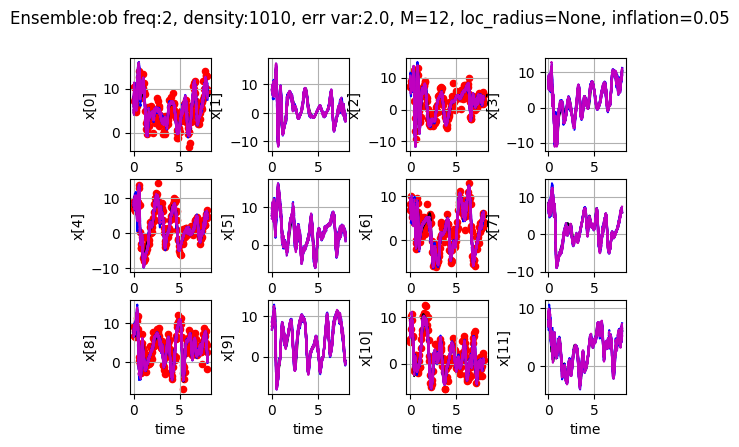

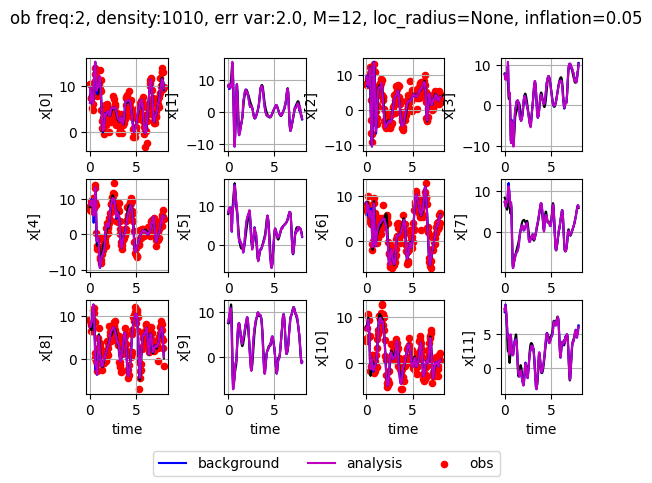

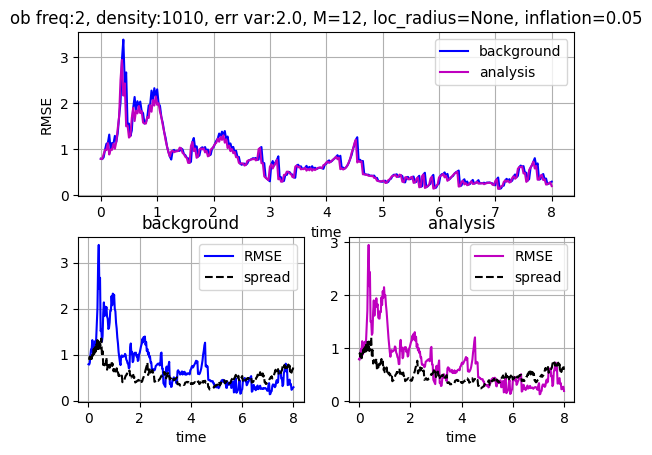

In [7]:
#Run the experiment
exp = LocalisationExperiment(x0 = xguess, t=t, xt=xt)
exp.run()

#Plot state and error metrics. 
exp.plot_state()
exp.plot_metrics(1)

#Calculate the root-mean-square values over time. 
np.sqrt((exp.calculate_metrics(1)**2).mean(dim=['time'])).to_dataframe()

We see that the RMSE grows considerably larger than the ensemble spread. Here we will 
test whether localisation can fix this. 

With domain localisation the stochastic ensemble Kalman filter correction for ensemble member $n$ becomes 
\begin{equation}
x^{a,(n)} = x^{b,(n)} 
+ (\mathbf{L} \circ \mathbf{P}^{f}) \mathbf{H}^{\rm{T}} (\mathbf{R}+\mathbf{H} (\mathbf{L} \circ \mathbf{P}^{f})\mathbf{H}^{\rm{T}})^{-1}
(y - \mathbf{H} x^{b,(n)} + \mathbf{R}^{\frac{1}{2}}\epsilon^{(n)})
\end{equation}
with $\circ$ the Hadamard, or elementwise, product and $\mathbf{L}$ the localisation matrix.  

To illustrate the effect of ensemble size and localisation we first run the experiment with a large ensemble 
of 256 members and plot the intial background error covariance together with its eigenvalues. 

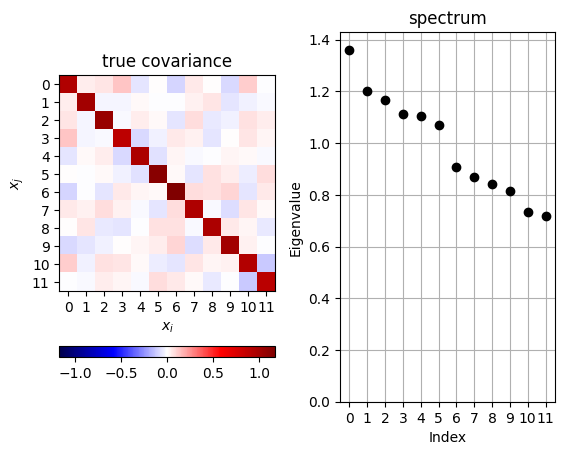

In [8]:
#Run the experiment
exp = LocalisationExperiment(x0 = xguess, t=t, xt=xt, n_ens=256)
exp.run()

#Plot the covariance at t=0 together with its eigenvalues. 
P = np.cov(exp.Xb[:,:,0])
plot_LocMatrix(P, name='true covariance')  

7. Plot the initial background covariance, but now from an ensemble with `n_ens=12` members. Is the background error
covariance and its spectrum the same as the one obtained from 256-member ensemble?

In order for our 12-member ensemble covariance to give a closer approximation to the true covariance,
we are going to apply localisation. The localisation weights every element in the background error covariance matrix. Elements on the diagonal are multiplied
by 1, while those off the diagonal are multiplied with values $<1$ that decrease as the elements are located further
from the diagonal. I.e. we are going to look at $\mathbf{L} \circ \mathbf{P}^{f}$, the domain localisation 
case in which the observation operator $\mathbf{H}$ is the identity. 

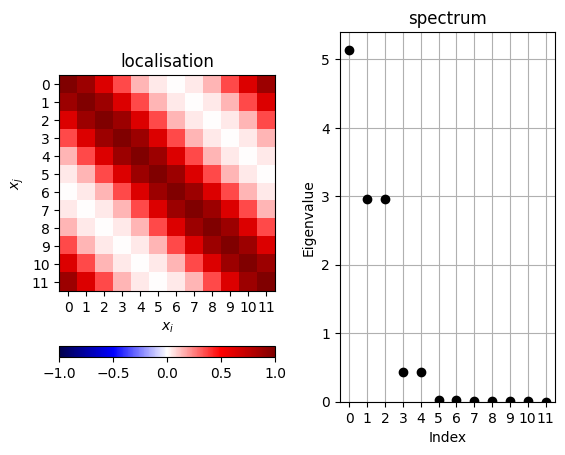

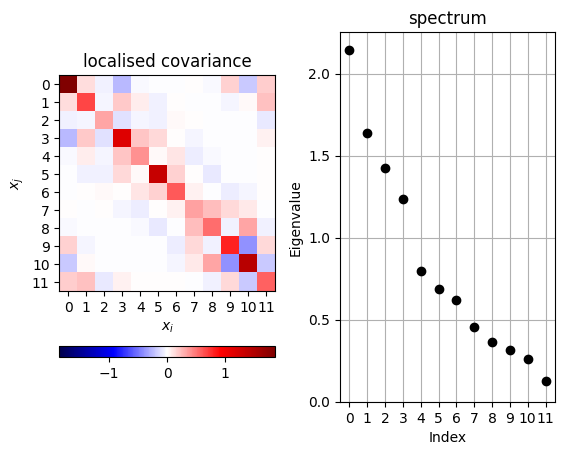

In [9]:
#Run the experiment
exp = LocalisationExperiment(x0 = xguess, t=t, xt=xt, loc_radius=2.0)
exp.run()

#Plot the localisation matrix. 
plot_LocMatrix(np.array(exp.L_x), name='localisation')

#Localise background error matrix by taking the Hadamard product with the localisation matrix. 
P = np.cov(exp.Xb[:,:,0]) * exp.L_x

#Plot the localised background error covariance matrix. 
plot_LocMatrix(P, name='localised covariance')

8. Compare the localised covariance with the one from the 256-member ensemble. What is the effect of localisation on the
the covariance matrix and what is the effect on its spectrum?

9. Run the using settings `x0 = xguess, loc_radius=2.0` like in the previous experiment. 
Plot the RMSE using `exp.plot_metrics()`. Does the application of localisation reduce the RMSE?

10. Repeat experiment 9 `for loc_radius in [None, 1.0, 2.0, 5.0, 9.0]`. Which localisation radius gives you the 
lowest RMSE? At which `loc_radius` do you get the lowest RMSE if you also pass `n_ens=24` as argument to 
`LocalisationExperiment`? What do you conclude about the nature of the (qualitative) relation between 
the optimal localisation radius and the ensemble size?

11. In the previous section, we explained that the RMSE and ensemble spread should, on average,
be equal. We also showed that ensemble inflation can be used to achieve this. For `n_ens=12` and 
`for loc_radius in [None, 2, 5]` find the smallest nonnegative value of `inflation` for which RMSE and 
ensemble spread are approximately equal over the simulation period. How does the localisation radius 
impact the need for inflation?

12. Time permitting repeat experiment 10 using `obs_grid = 'landsea'`. How does the design of the observation network impact
the need for localisation?